<a href="https://colab.research.google.com/github/levhojoyan/thesis/blob/main/Wine/ExperimentForWine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset, DataLoader


from IPython import display
import time

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import pandas as pd

red = False

if red:
    wine = pd.read_csv("/content/drive/MyDrive/HSE/Diploma/Wine/winequality-red.csv")
else:
    wine = pd.read_csv("/content/drive/MyDrive/HSE/Diploma/Wine/winequality-white.csv", sep=';')

y = wine.quality
X = wine.drop(columns=['quality'])

In [ ]:
X.shape

In [ ]:
batch_size = 128
epochs = 150

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {'sample': torch.tensor(self.x.iloc[idx], dtype=torch.float), 'target': self.y.iloc[idx]}

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
X_train_tensor = torch.from_numpy(X_train.values).float()
X_test_tensor = torch.from_numpy(X_test.values).float()

y_train_tensor = torch.from_numpy(y_train.values).float()
y_test_tensor = torch.from_numpy(y_test.values).float()

train_torch = TensorDataset(X_train_tensor, y_train_tensor)
val_torch = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_torch, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_torch, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
X_train_tensor.shape, X_test_tensor.shape

In [ ]:
class Template(nn.Module):
    def __init__(self, input_shape, output_shape=5):
        super(Template, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.convs = nn.Sequential(
                          nn.Linear(self.input_shape, 8),
                          nn.ReLU(),
                          nn.Linear(8, 3),
                          nn.ReLU(),
                          nn.Linear(3, 8),
                          nn.ReLU(),
                          nn.Linear(8, output_shape),
                          nn.ReLU(),
                          )


    def forward(self, x):
        for conv in self.convs:
          x = F.relu(conv(x))
        return x

In [ ]:
class Model(nn.Module):
    def __init__(self, input_shape):
        super(Model, self).__init__()
        self.input_shape = input_shape
        self.template = Template(self.input_shape)
        self.conv2 = nn.Linear(self.template.output_shape, 1)

    def forward(self, x):
      x = self.template(x)

      return self.conv2(x)

    def count_loss(self, X, y):
        return self.count_mse(X, y)

    def count_mse(self, X, y):
        
        y_pred_functions = self.forward(X)
        
        # print(y_pred_functions.shape, y.shape)
        assert y_pred_functions.shape == y.reshape(-1, 1).shape

        mse = torch.nn.MSELoss()(y_pred_functions, y.reshape(-1, 1))

        return mse

class ModelWithWeighted(nn.Module):
    def __init__(self, input_shape, output_models=10):
        super(ModelWithWeighted, self).__init__()

        self.input_shape = input_shape

        self.conv1 = Template(input_shape) # the simpliest
        self.conv2 = nn.Linear(self.conv1.output_shape, output_models) # the simpliest

        self.weights = nn.Parameter(torch.zeros(output_models, requires_grad=True))


    def forward(self, x):
        x = self.conv1(x)
        return self.conv2(x)

    
    def count_loss(self, X, y):
        norm_weights = F.softmax(self.weights, dim=0)

        y_pred_functions = self.forward(X)

        total_pred = torch.sum(y_pred_functions * norm_weights, dim=-1)

        # print('kek1')
        # print(y_pred_functions.shape, y.shape)
        # assert y_pred_functions.shape == y.shape
        
        weighted_mse = torch.sum(norm_weights * ((y_pred_functions - y.reshape(-1, 1))**2))

        # print(total_pred.shape, y.shape)
        # print('kek2')

        assert total_pred.shape == y.shape
        # print('kek3')

        mse = torch.nn.MSELoss()(total_pred, y)

        return mse + weighted_mse

    def count_mse(self, X, y):
        norm_weights = F.softmax(self.weights, dim=0)

        y_pred_functions = self.forward(X)

        total_pred = torch.sum(y_pred_functions * norm_weights, dim=-1)
        
        assert total_pred.shape == y.shape

        mse = torch.nn.MSELoss()(total_pred, y)

        return mse

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def train_and_get_log_Q():
    learning_rate = 1e-2
    model2 = ModelWithWeighted(X_train.shape[1])
    optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.985)

    log_weights = {}

    log_weights['train_losses'] = []
    log_weights['test_losses'] = []

    epochs = 105

    for i, epoch in enumerate(range(epochs)):
        for x_batch, y_batch in train_dataloader:
            loss = model2.count_loss(x_batch, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()

        with torch.no_grad():
            test_mse = model2.count_mse(X_test_tensor, y_test_tensor).item()
            train_mse = model2.count_mse(X_train_tensor, y_train_tensor).item()

            log_weights['train_losses'].append(train_mse)
            log_weights['test_losses'].append(test_mse)

        lr = get_lr(optimizer)

    #     print(
    #         f"[{epoch}/{epochs}]\t Training loss: {train_mse:8.4f}\t Validation loss: {test_mse:8.4f}\t Learning rate: {lr:8.4f}"
    #     )

    # plt.plot(log_weights['test_losses'][20:], c='b', label='test')
    # plt.plot(log_weights['train_losses'][20:], c='r', label='train')
    # plt.legend()
    # plt.show()

    return log_weights['test_losses']

# _ = train_and_get_log_Q()

In [ ]:
def train_and_get_log_default():
    learning_rate = 0.07
    model = Model(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    log_original = {}

    log_original['train_losses'] = []
    log_original['test_losses'] = []

    epochs = 105

    for i, epoch in enumerate(range(epochs)):
        for x_batch, y_batch in train_dataloader:
            loss = model.count_loss(x_batch, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()


        with torch.no_grad():
            test_mse = model.count_mse(X_test_tensor, y_test_tensor).item()
            train_mse = model.count_mse(X_train_tensor, y_train_tensor).item()

            log_original['train_losses'].append(train_mse)
            log_original['test_losses'].append(test_mse)

        lr = get_lr(optimizer)

        # print(
        #     f"[{epoch}/{epochs}]\t Training loss: {train_mse:8.4f}\t Validation loss: {test_mse:8.4f}\t Learning rate: {lr:8.4f}"
        # )

    # plt.plot(log_original['test_losses'][20:], c='b', label='test')
    # plt.plot(log_original['train_losses'][20:], c='r', label='train')
    # plt.legend()
    # plt.show()

    return log_original['test_losses']

In [ ]:
torch.manual_seed(0)
Q_story = []
for _ in tqdm(range(100)):
    l = train_and_get_log_Q()
    Q_story.append(l[100])

np.mean(Q_story), np.std(Q_story)

In [ ]:
Q_story

In [ ]:
torch.manual_seed(0)
story = []
for _ in tqdm(range(100)):
    log_original = train_and_get_log_default()
    story.append(log_original[100])

np.mean(story), np.std(story)

  0%|          | 0/100 [00:00<?, ?it/s]

(0.6352674621343612, 0.09325426889947433)

In [ ]:
story

[0.7559934854507446,
 0.755177915096283,
 0.5625780820846558,
 0.7697194218635559,
 0.632752537727356,
 0.7573242783546448,
 0.755609929561615,
 0.5795725584030151,
 0.7551267743110657,
 0.771098256111145]

In [ ]:
s = 0

TypeError: ignored

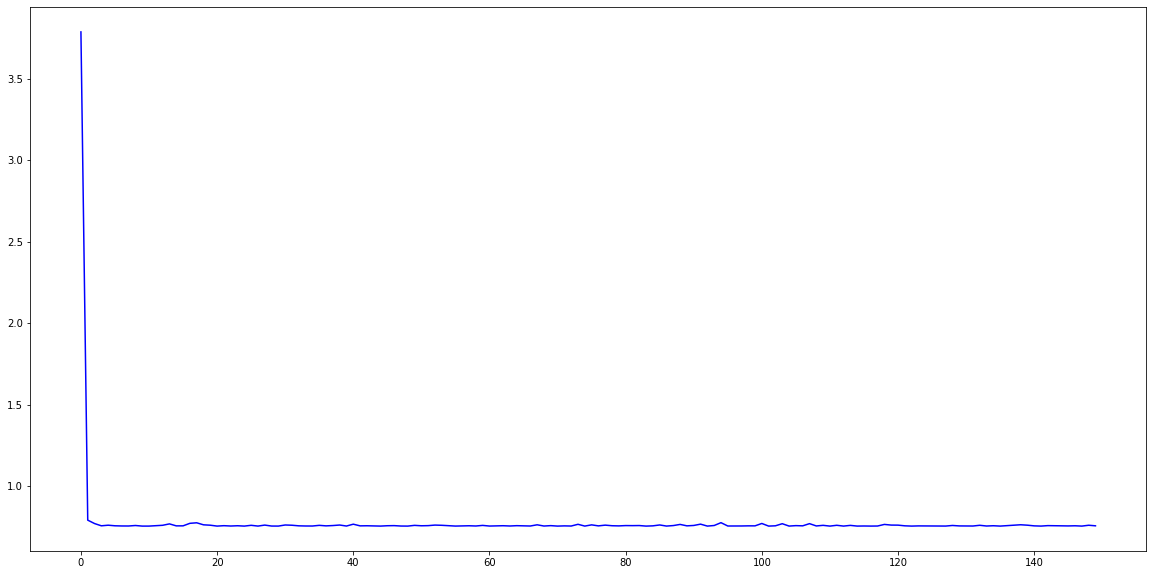

In [ ]:
s = 0
plt.figure(figsize=(20, 10))
plt.plot(log_original[s:], c='b', label='original')
plt.plot( log_weights[s:], c='r', label='Q-aggregation')
plt.ylabel('Risk on test data')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(log_original['test_losses'][s:])), log_original['test_losses'][s:], c='b', label='original')
plt.plot(range(len(log_weights['test_losses'][s:])), log_weights['test_losses'][s:], c='r', label='Q-aggregation')
plt.ylabel('Risk on test data')
plt.xlabel('Epochs')
plt.legend()